In [1]:
import dataset
from listwise_ltr import listwise_ltr
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
import numpy as np

In [2]:
class ListDataSet(Dataset):
    
    def __init__(self, fold):
        self.fold = fold
    
    def __len__(self):
        return self.fold.num_queries()
    
    def __getitem__(self, index):
        return self.fold.query_feat(index), self.fold.query_labels(index)

In [3]:
class LambdaRankLoss(torch.nn.Module):
    '''
    input: predictions and target
    output: scalar loss 
    '''
    
    def __init__(self, gamma):
        super(LambdaRankLoss, self).__init__()
        self.gamma = gamma
    
#     def forward(self, y_hat, y):
#         loss = torch.tensor(0., requires_grad=True)
#         for i, z in enumerate(y):
#             indices = torch.where(y>z)[0]
#             if len(indices) > 0:
#                 loss += torch.log(1 + torch.exp(-self.gamma * (y_hat[indices]-y_hat[i]))).sum()
                
#         return loss

    def forward(self, y_hat, y):
        loss = torch.zeros_like(y_hat)
        
        for i, z in enumerate(y):
            loss += torch.log(1 + torch.exp(-self.gamma * (y_hat-y_hat[i]))) * (y>z)
                
        return loss.sum()
    
    def backward(self, y_hat, y):
        """
        Backward pass. 
        
        Args:
            dout: gradients of the previous module
        Returns:
            dx: gradients with respect to input, weighted by
            absolute change in NDCG
        """
        
        # get |NDCG|
        dy = torch.zeros_like(y_hat)
        delta = torch.zeros_like(y_hat)
        ndcg_norm = (2**y_sorted / torch.arange(2, len(y)+2).float().log()).sum()
        for i, z in enumerate(y):
#             indices = torch.where(y>z)[0]
#             if len(indices) > 0:
                
            subset1 = (y_hat-y_hat[i])>0
            term = self.gamma * (1-(self.gamma*(y_hat-y_hat[i])).sigmoid())

            dy += term * subset1
            dy[i] -= term.sum()
            
            # add new positions
            delta += subset1 * (2*y[i]) / torch.log(torch.arange(2,len(y_hat)+2))
            delta[i] += (subset1 * 2**y).sum() / torch.log(i+2)
            
            # remove current positions
            delta -= subset1 * (2*y) / torch.log(torch.arange(2,len(y_hat)+2))
            delta[i] -= subset1.sum() * 2**y[i] / torch.log(i+2)
            
                
        return dy * torch.abs(delta) / ndcg_norm
    
    

In [4]:
N_EPOCHS = 10

In [5]:
data= dataset.get_dataset()
data = data.get_data_folds()[0]
data.read_data()



In [6]:
train_dataset = ListDataSet(data.train)
valid_dataset = ListDataSet(data.validation)
test_dataset = ListDataSet(data.test)

In [7]:
train_dl = DataLoader(train_dataset, shuffle=True)
valid_dl = DataLoader(valid_dataset)
test_dl = DataLoader(test_dataset)

In [8]:
model = listwise_ltr.Listwise()
model.cuda()

Listwise(
  (nnet): Sequential(
    (0): Linear(in_features=501, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=1, bias=True)
    (3): ReLU()
  )
)

In [9]:
optimizer = torch.optim.Adam(model.parameters())
critereon = LambdaRankLoss(gamma=1)

In [10]:
def ndcg(y_hat, y):
    
    def dcg(y_hat, y):
        sort_indices = y_hat.sort(descending=True)[1]
        
        return ( 2**y[sort_indices].float() / torch.arange(2, len(y)+2).cuda().float().log() ).sum()
    
    return dcg(y_hat, y) / dcg(y, y)

In [11]:
train_loss = defaultdict(list)
valid_loss = defaultdict(list)
train_ndcg = defaultdict(list)
valid_ndcg = defaultdict(list)


for epoch in range(N_EPOCHS):
    
    # iterate over training set
    with tqdm(total=len(train_dl)) as t:
        model.train()
        t.set_description(f'Epoch: {epoch+1}/{N_EPOCHS}')
        for ix, (X,y) in enumerate(train_dl):
            X = X.cuda().float().squeeze(0)
            y = y.cuda().float().squeeze(0)


            y_hat = model(X).squeeze(1)
            

            
            # compute loss
            loss = critereon(y_hat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss[epoch].append(loss.item())
            ndcg_batch = ndcg(y_hat, y).item()
            train_ndcg[epoch].append(ndcg_batch)
            if ix%50 == 0:
                t.set_postfix_str(f'train loss: {loss.item():.3f}\t train NDCG: {ndcg_batch:.3f}')
            t.update()
            
        mean_train_ndcg = np.mean(train_ndcg[epoch])
        mean_train_loss = np.mean(train_loss[epoch])

        # validate
        with torch.no_grad():
            model.eval()
            for ix, (X,y) in enumerate(valid_dl):
                X = X.cuda().float().squeeze(0)
                y = y.cuda().float().squeeze(0)

                y_hat = model(X).squeeze(1)
    #             print(y_hat.shape)


                # compute loss
                loss = critereon(y_hat, y)
                ndcg_batch = ndcg(y_hat, y).item()

                valid_loss[epoch].append(loss.item())

                valid_ndcg[epoch].append(ndcg_batch)
                if ix % 50 == 0:
                    t.set_postfix_str(f'train loss: {mean_train_loss:.3f}\t train NDCG: {mean_train_ndcg:.3f}\t valid loss: {loss.item():.3f}\t valid NDCG: {ndcg_batch:.3f}')

        mean_valid_ndcg = np.mean(valid_ndcg[epoch])
        mean_valid_loss = np.mean(valid_loss[epoch])

        t.set_postfix_str(f'train loss: {mean_train_loss:.3f}\t train NDCG: {mean_train_ndcg:.3f}\t valid loss: {mean_valid_loss:.3f}\t valid NDCG: {mean_valid_ndcg:.3f}')
        
    
        
        
        
        
        
    

Epoch: 10/10: 100%|█| 19943/19943 [09:23<00:00, 38.44it/s, train loss: 179.977	 train NDCG: 0.819	 valid loss: 184.306	 valid NDCG: 0.819]


In [103]:
[np.mean(train_loss[epoch]) for epoch in train_loss]

[41.92290489982081]

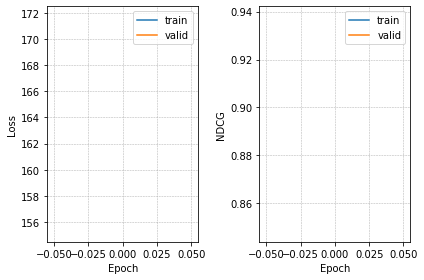

In [32]:
# train loop
def plot_loss_ndcg(train_loss, valid_loss, train_ndcg, valid_ndcg):
    f, (ax1, ax2) = plt.subplots(1,2)
    
    ax1.plot([np.mean(train_loss[epoch]) for epoch in train_loss], label='train')
    ax1.plot([np.mean(valid_loss[epoch]) for epoch in valid_loss], label='valid')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    
    ax2.plot([np.mean(train_ndcg[epoch]) for epoch in train_ndcg], label='train')
    ax2.plot([np.mean(valid_ndcg[epoch]) for epoch in valid_ndcg], label='valid')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('NDCG')
    
    
    
    ax1.grid(linewidth=0.5, linestyle='--')
    ax1.legend()
    
    ax2.grid(linewidth=0.5, linestyle='--')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
plot_loss_ndcg(train_loss, valid_loss, train_ndcg, valid_ndcg)


## tryout

In [22]:
y_hat = torch.Tensor([1, 2, 2.5, 0.7, 0, .4])
y     = torch.Tensor([1, 2, 3, 2, 1, 2])

In [46]:
y_hat

tensor([1.0000, 2.0000, 2.5000, 0.7000, 0.0000, 0.4000])

In [47]:
y

tensor([1., 2., 3., 2., 1., 2.])

In [42]:
indices = torch.where(y>z)
indices

(tensor([2]),)

In [43]:
y_hat[indices]

tensor([2.5000])

In [76]:
# loop over absolute differences
loss = 0
gamma = 1
for i, z in enumerate(y):
    indices = torch.where(y>z)[0]
    if len(indices) > 0:
        loss += torch.log(1 + torch.exp(-gamma * (y_hat[indices] - y_hat[i]))).sum()
    

Wall time: 1.99 ms


In [65]:
loss

tensor(4.2711)